In [1]:
%matplotlib inline
from matplotlib import pyplot as plot
from matplotlib import figure 

# Maze

### Distance Units: cm

In [42]:
class Block:
    
    def __init__(self, bottom_left, bottom_right, top_right, top_left):
        self.points = [
            bottom_left,
            bottom_right,
            top_right,
            top_left,
            bottom_left
        ]
    
    def intersects(self, other_block):

        if min(self.getX()) > max(other_block.getX()) or max(self.getX()) < min(other_block.getX()):
            return False

        if min(self.getY()) > max(other_block.getY()) or max(self.getY()) < min(other_block.getY()):
            return False

        else:
            return True        
    
    def getX(self):
        
        return [p[0] for p in self.points]
    
    def getY(self):
        
        return [p[1] for p in self.points]
        
class Maze:
    
    def __init__(self, size = (10,10), blocks = [], robot = None):
        
        self.size = size
        self.aspect_ratio = self.size[1] / self.size[0]
        self.blocks = blocks
        self.robot = robot
        self._createMazeWalls()
        
    def _createMazeWalls(self):
        
        thickness = 1 # cm
        
        wall_b = Block((-thickness,-thickness), (self.size[0]+thickness, -thickness), (self.size[0]+thickness, 0), (-thickness,0))
        wall_t = Block((-thickness, self.size[1]), (self.size[0]+thickness, self.size[1]), (self.size[0]+thickness, self.size[1]+thickness), (-thickness,self.size[1]+thickness))
        wall_l = Block((-thickness,0), (0,0), (0, self.size[1]), (-thickness,self.size[1]))
        wall_r = Block((self.size[0],0), (self.size[0]+thickness,0), (self.size[0]+thickness, self.size[1]), self.size)
        
        for wall in [wall_b, wall_t, wall_l, wall_r]:
            self.blocks.append(wall)
        
    def robotIntersects(self):
        
        # Check with walls
        for wall in self.blocks:
            if self.robot.intersects(wall):
                return True
            
        return False
    
    def show(self, size = 5):
        
        plot.rcParams["figure.figsize"] = (size,size*self.aspect_ratio)
        
        # Border
        plot.ylim(-1,self.size[1]+1)
        plot.xlim(-1,self.size[0]+1)
        plot.plot([
            0, 
            self.size[0],  
            self.size[1],  
            0,
            0],
            [0,
             0,
             self.size[1],
             self.size[1],
             0
            ], color = "orange", label="Maze")
        
        # Walls
        for block in self.blocks:
            plot.plot(block.getX(), block.getY(), color='orange')
            plot.fill_between(block.getX(), block.getY(), facecolor='orange')
            
        # Robot
        if self.robot:
            plot.plot(self.robot.getX(), self.robot.getY(), label="Robot", color='blue')
            
            # Motor
            for motor in self.robot.motors:
                vector = motor.getVector()
                plot.plot([p[0] for p in vector],[p[1] for p in vector], label="Motor", color="red")            
            
            # Sensors
        
        
        plot.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plot.show()
    
    def __repr__(self):
        self.show()
        return 'None'

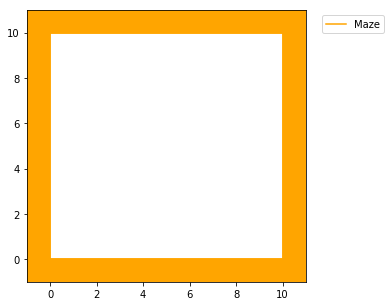

In [43]:
block = Block((0,0), [1,0], [1,1], [0,1])
maze = Maze(blocks=[])
maze.show()

## Geometry

In [26]:
def translate(points, x, y):
    move_x = [(p[0]+x, p[1]) for p in points]
    move_y = [(p[0], p[1]+y) for p in move_x]
    
    return move_y   

def centroid(points):
    xs = [p[0] for p in points[:-1]]
    ys = [p[1] for p in points[:-1]]

    return sum(xs)/4, sum(ys)/4

def rotate(points, theta, rad=False):
        
    '''
    Rotate around centroid. 
    theta in rad
    '''
    if not rad:
        theta = math.radians(theta)

    matrix = [
        [cos(theta), -1*sin(theta)],
        [sin(theta), cos(theta)]
    ]

    # 1 - Translate points
    original_center = centroid(points)
    points = translate(points, -original_center[0], -original_center[1])

    # 2 - Rotate
    points = [np.matmul(matrix, point) for point in points]

    # 3 - Translate back
    points = translate(points, original_center[0], original_center[1])

    return points

## Motor + Sensor

In [78]:
from math import tan, atan, pi

class Motor:
    def __init__(self, speed_coeff, mount_pos, mount_direction, wheel_radius = 1):
        self.speed_coeff = speed_coeff
        self.mount_dist = mount_pos
        self.mount_pos = mount_pos
        self.mount_direction = mount_direction
        self.wheel_radius = wheel_radius
        
    def getVector(self):
        point1 = self.mount_pos
        point2 = (self.mount_pos[0] + self.wheel_radius, self.mount_pos[1]) # make vector along on x-axis
        points = [point1, point2]
        print(points)
        
        if self.mount_direction[0] == 0:
            theta = pi
        else:
            theta = atan(self.mount_direction[1] / self.mount_direction[0])
            
        rotated_points = rotate(points, theta+pi/2, rad=True)
         
        return rotated_points
        

In [79]:
class Sensor:
    
    def __init__(self, mount_pos, mount_direction):
        
        self.mount_pos = mount_pos
        self.mount_direction = mount_direction
        self.mount_dist = mount_pos

# Robot

In [80]:
import numpy as np
import math
from math import sin, cos

class Robot(Block):
    
    '''
    Omni directional robot.
    
    Args:
    - motors = list of Motor(s)
    - sensors = list of Sensor(s)
    '''
    
    def __init__(self, size, origin = (0,0), motors = [], distance_sensors = []):
        
        super().__init__([0,0], [size[0], 0], [size[0], size[1]], [0, size[1]])
        self.size = size #x,y
        self.motors = motors
        self.distance_sensors = distance_sensors
        self.centroid = self.calcCentroid()
        self._points = self.points
        self.translate(origin[0], origin[1])
    
    @property
    def points(self):
        return self._points

    @points.setter
    def points(self, val):
        self._points = val
        self.calcCentroid()
        
        # Move shit
        
    
    def getOrigin(self):
        return self.points[0]
    
    def calcCentroid(self):
        self.centroid = centroid(self.points)
    
    def translate(self, translate_x, translate_y, set_points = True):
        
        points = translate(self.points, translate_x, translate_y)
        
        if set_points:
            self.points = points
        
        return points
    
    def rotate(self, theta, rad=False):
        
        self.points = rotate(self.points, theta, rad)
        
        return self.points

In [81]:
block1 = Block((0,3), [10,3], [10,4], [0,4])
block2 = Block((0,6), [10,6], [10,7], [0,7])
maze = Maze(size = (10,10), blocks=[block1, block2])

[(1, 1), (2, 1)]


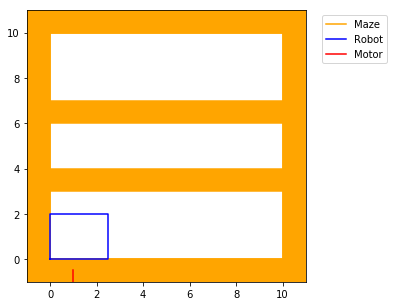

In [82]:
motor1 = Motor(0.5, (1,1), (0,1))
maze.robot = Robot((2.5,2), motors=[motor1])
maze.show()

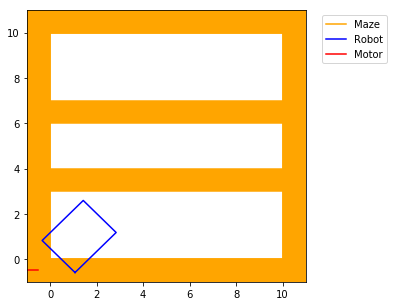

In [62]:
maze.robot.rotate(45)
maze.show()